# Quanvolutional Neural Network

## Convolutional Neural Network

<center>
    <figure>
        <img src="images/cnn.png" width=50%>
        <figcaption> CNNs to classify handwritten digits</figcaption>
    </figure>
</center>

**Convolutional neural networks** or **CNNs** are type of machine learning model, often used in image analysis and computer vision applications. The major pro for these models come from their ability to extract features from the data in a hierarchical manner. The per-processing required in a CNNs is much lower as compared to other classification algorithms. While in primitive methods are hand-engineered , with enough training, ConvNets have the ability to learn these filters.

## Quanvolutional Neural Network

<center>
    <figure>
        <img src="images/quanvolutional.png" width=50%>
    </figure>
</center>

**Quantum Neural Network (QNN)** extend the capabilities of **CNNs** by introducing a new type of transformed layer: **Quanvolutional layer**. They are made up of a group of N quantum filters (random quantum circuits), making a feature map through the transformed input data. It is hypothesized that quanvolutional features would increase the accuracy of ML models. This will be only because of two reasons:

1. **Quanvolutional filter** are applied to only *local subsections* of the input data, so they can operate using a small number of quantum bits with shallow gate depths.
2. **Quanvolutional are resilient to error**; as long as the error model in the quantum circuit is consistent, it can essentially be thought as another component of the random quantum circuit.


# Implementation of Quanvolutional Neural Networks

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
n_epochs = 50   # Number of optimization epochs
n_layers = 2    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/"  # Data saving folder
PREPROCESS = False           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(42)           # Seed for NumPy random number generator
tf.random.set_seed(42)       # Seed for TensorFlow random number generator

# Loading the MNIST data

In [3]:
# keras has pre-loaded datasets, you can select any for your work
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

# Quantum circuit as Convolutional Kernel

In [4]:
dev = qml.device("default.qubit", wires=4)

# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

phis = np.random.random(4)
print(qml.draw(circuit)(phis))

0: ──RY(2.04)─╭RandomLayers(M0)─┤  <Z>
1: ──RY(0.18)─├RandomLayers(M0)─┤  <Z>
2: ──RY(2.27)─├RandomLayers(M0)─┤  <Z>
3: ──RY(2.95)─╰RandomLayers(M0)─┤  <Z>

M0 = 
[[1.15255478 4.89894304 3.75012014 2.8012498 ]
 [0.62816092 2.88554589 2.09675304 0.89765869]]


The next function defines the convolutional scheme:
1. the image is divided into 2x2 pixels squares
2. each square is processed by the quantum circuit
3. the four expectation values are mapped into four different channels of a single output pixel.

> This processes halves the resolution of the input image. In classical Ml, this corresponds a 2x2 convolutional with two as stride length.

In [5]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

# Quantum Pre-processing

Since we are not going to train the quantum convolution layer, it is more efficient to apply it as a “pre-processing” layer to all the images of our dataset. Later an entirely classical model will be directly trained and tested on the pre-processed dataset, avoiding unnecessary repetitions of quantum computations.

The preprocessed images will be saved in `SAVE_PATH`. Once saved, they can be directly loaded by setting `PREPROCESS = FALSE`.

In [6]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

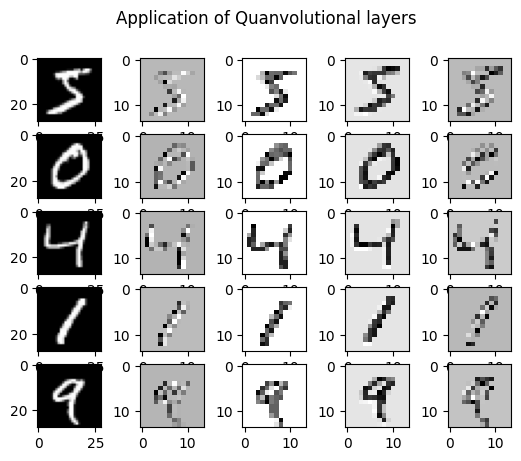

In [7]:
fig, ax = plt.subplots(5, 5)
for img_id in range(5):
    img = train_images[img_id]
    img_qanv = quanv(img)
    ax[img_id, 0].imshow(img, cmap='gray')
    for i in range(4):
        ax[img_id, i+1].imshow(img_qanv[:, :, i], cmap='gray')

fig.suptitle("Application of Quanvolutional layers")
plt.savefig("images/quanvolutional_output.png")
plt.show()

# Hybrid Classical-Quantum Model

Feeding the features into a classical neural network.

In [8]:
def model():
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Training

### Quantum Model

In [9]:
q_model = model()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/50
13/13 - 1s - 77ms/step - accuracy: 0.0400 - loss: 2.5540 - val_accuracy: 0.3333 - val_loss: 2.1903
Epoch 2/50
13/13 - 0s - 8ms/step - accuracy: 0.2800 - loss: 2.0366 - val_accuracy: 0.2000 - val_loss: 2.0700
Epoch 3/50
13/13 - 0s - 11ms/step - accuracy: 0.4800 - loss: 1.8230 - val_accuracy: 0.3000 - val_loss: 1.9816
Epoch 4/50
13/13 - 0s - 8ms/step - accuracy: 0.6200 - loss: 1.5989 - val_accuracy: 0.4000 - val_loss: 1.8849
Epoch 5/50
13/13 - 0s - 9ms/step - accuracy: 0.7600 - loss: 1.3861 - val_accuracy: 0.4333 - val_loss: 1.7984
Epoch 6/50
13/13 - 0s - 8ms/step - accuracy: 0.8200 - loss: 1.2039 - val_accuracy: 0.5000 - val_loss: 1.7262
Epoch 7/50
13/13 - 0s - 8ms/step - accuracy: 0.8600 - loss: 1.0515 - val_accuracy: 0.5333 - val_loss: 1.6642
Epoch 8/50
13/13 - 0s - 9ms/step - accuracy: 0.9000 - loss: 0.9216 - val_accuracy: 0.5333 - val_loss: 1.6098
Epoch 9/50
13/13 - 0s - 10ms/step - accuracy: 0.9600 - loss: 0.8099 - val_accuracy: 0.5333 - val_loss: 1.5624
Epoch 10/50
13/1

### Classical Model

In [14]:
c_model = model()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/50
13/13 - 1s - 87ms/step - accuracy: 0.1600 - loss: 2.3715 - val_accuracy: 0.1333 - val_loss: 2.3721
Epoch 2/50
13/13 - 0s - 9ms/step - accuracy: 0.3600 - loss: 1.9329 - val_accuracy: 0.3000 - val_loss: 2.1767
Epoch 3/50
13/13 - 0s - 10ms/step - accuracy: 0.6000 - loss: 1.6305 - val_accuracy: 0.3000 - val_loss: 2.0172
Epoch 4/50
13/13 - 0s - 8ms/step - accuracy: 0.7200 - loss: 1.3938 - val_accuracy: 0.4000 - val_loss: 1.8819
Epoch 5/50
13/13 - 0s - 9ms/step - accuracy: 0.8000 - loss: 1.2000 - val_accuracy: 0.5000 - val_loss: 1.7696
Epoch 6/50
13/13 - 0s - 9ms/step - accuracy: 0.8600 - loss: 1.0395 - val_accuracy: 0.5000 - val_loss: 1.6787
Epoch 7/50
13/13 - 0s - 12ms/step - accuracy: 0.8800 - loss: 0.9066 - val_accuracy: 0.5333 - val_loss: 1.6048
Epoch 8/50
13/13 - 0s - 11ms/step - accuracy: 0.9000 - loss: 0.7964 - val_accuracy: 0.5333 - val_loss: 1.5434
Epoch 9/50
13/13 - 0s - 7ms/step - accuracy: 0.9200 - loss: 0.7042 - val_accuracy: 0.5667 - val_loss: 1.4914
Epoch 10/50
13/

## Results

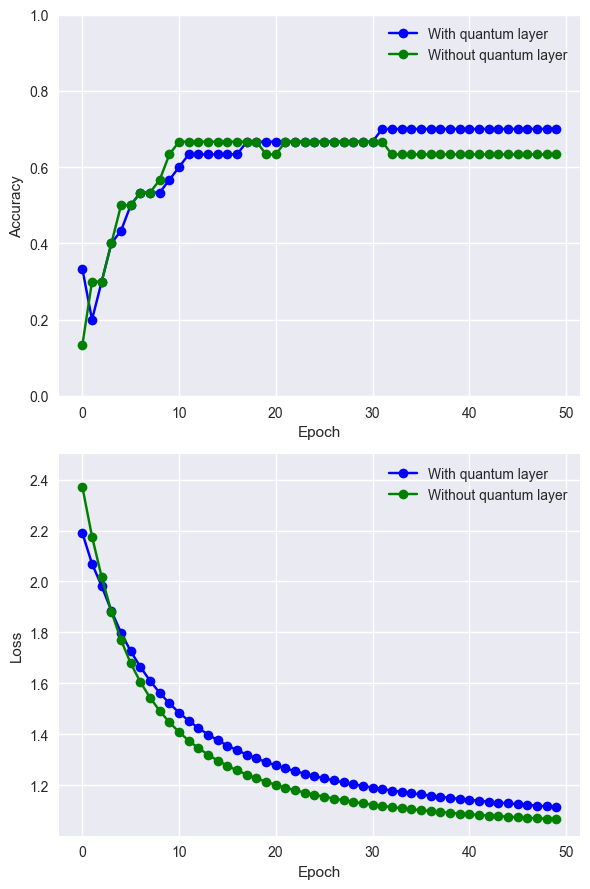

In [15]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

# Resources
- [Quanvolutional Neural Network - Henderson et al](https://arxiv.org/abs/1904.04767)
- [Quanvolutional Neural Network - Monit Sharma - Medium](https://medium.com/@_monitsharma/quanvolutional-neural-networks-powering-image-recognition-with-quantum-circuits-388e2567fe9)
- [Implementing QCNN - Arnaud Robin - Medium](https://medium.com/mit-6-s089-intro-to-quantum-computing/quanvolutional-neural-networks-might-be-the-future-of-deep-learning-heres-why-5377bfc03652)
- [Quanvolutional Neural Network - PennyLane Demo](https://pennylane.ai/qml/demos/tutorial_quanvolution/)
- [Trainable QuantumConvolution - GitHub](https://github.com/PlanQK/TrainableQuantumConvolution)
- [ResQuNNs:Towards Enabling Deep Learning in Quantum Convolution Neural Networks - Kashif and Shafique - Arxiv](https://arxiv.org/abs/2402.09146)